In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install conllu

from io import open
from conllu import parse_incr
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import re
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

data_file = open("/content/drive/My Drive/zh_gsd-ud-train.conllu", "r", encoding="utf-8")

# save dataset
sentences_list = []
pos_list = []

for tokenlist in parse_incr(data_file):
    temp_str = []
    temp_pos = []
    for s in tokenlist:
        temp_str.append(s['form'])
        temp_pos.append(s['upos'])
    sentences_list.append(temp_str)
    pos_list.append(temp_pos)
    

In [ ]:
train_sentence = sentences_list[:3500]
train_pos = pos_list[:3500]

test_sentence = sentences_list[3500:]
test_pos = pos_list[3500:]

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec model
emb_model = Word2Vec(sentences_list, size=250, window=5, min_count=1, workers=4, sg=1, hs=1, iter=50)
num_words = len(emb_model.wv.vocab) + 1
pad = '<pad>'
unk = '<unk>'
pad_id = 0
unk_id = 1

idx2word = {
  0: '<pad>',
}

word2idx = {
  '<pad>': 0,
}

count_idx2w = 1
count_w2idx = 1

In [ ]:
emb_matrix = np.zeros((num_words, 250), dtype=float)
for i in range(num_words - 1):
    v = emb_model.wv[emb_model.wv.index2word[i]]
    emb_matrix[i+1] = v   # Plus 1 to reserve index 0 for OOV words
    idx2word[count_idx2w] = emb_model.wv.index2word[i]
    word2idx[emb_model.wv.index2word[i]] = count_w2idx
    count_idx2w += 1
    count_w2idx += 1

In [ ]:
emb_matrix.shape

(17613, 250)

In [ ]:
assert len(idx2word) == len(word2idx)

In [ ]:
def add_dict(list_data: list, first_insert_list: list):
    dict_data = {}
    idx2dict = {}
    count = 0

    if len(first_insert_list) != 0:
      for ele in first_insert_list:
        if ele not in dict_data:
          dict_data[ele] = count
          idx2dict[count] = ele
          count += 1
    
    for first_ele in list_data:
        for second_ele in first_ele:
            if second_ele not in dict_data:
                dict_data[second_ele] = count
                idx2dict[count] = second_ele
                count += 1
    
    return dict_data, idx2dict

# 建立辭典
# dict_first_insert_word = [pad, unk]

# dict_words, idx2word = add_dict(sentences_list, [])
dict_pos, idx2pos = add_dict(pos_list, ['igner'])

In [ ]:
dict_pos

{'ADJ': 2,
 'ADP': 10,
 'ADV': 4,
 'AUX': 1,
 'CCONJ': 12,
 'DET': 11,
 'NOUN': 7,
 'NUM': 6,
 'PART': 9,
 'PRON': 8,
 'PROPN': 13,
 'PUNCT': 3,
 'SYM': 15,
 'VERB': 5,
 'X': 14,
 'igner': 0}

In [ ]:
# 建立數據集，餵給LSTM使用
class POS_Dataset(Dataset):
    def __init__(self, sentence_list, pos_list, word2idx, dict_pos):
        self.sentence_list = sentence_list
        self.pos_list = pos_list
        self.dict_words = word2idx
        self.dict_pos = dict_pos
    
    def __getitem__(self, idx):
        source = self.sentence_list[idx]
        target = self.pos_list[idx]

        data_X = [self.dict_words[w] for w in source]
        target_Y = [self.dict_pos[tag] for tag in target]
        
        data_X = torch.tensor(data_X, dtype=torch.long)
        target_Y = torch.tensor(target_Y, dtype=torch.long)
        
        return data_X, target_Y
        
    def __len__(self):
        return len(self.sentence_list)

In [ ]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_id)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=dict_pos['igner'])

  return xx_pad, yy_pad, x_lens, y_lens

batch_size = 100

dataset = POS_Dataset(train_sentence, train_pos, word2idx, dict_pos)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

test_dataset = POS_Dataset(test_sentence, test_pos, word2idx, dict_pos)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(sentences_list)-3500, shuffle=False, collate_fn=pad_collate)

In [ ]:
# 建立模型 inputs > nn.Embedding > nn.LSTM > nn.Dropout > 取最後一個 state > nn.Linear > softmax
class LSTM_Tagger(nn.Module):
    def __init__(self, n_hidden, num_layers, dropout_ratio, pos_size, weight):
        super(LSTM_Tagger, self).__init__()
        
        self.dropout = nn.Dropout(dropout_ratio)
        self.word_embeddings = nn.Embedding.from_pretrained(weight, padding_idx = 0)
        self.word_embeddings.weight.requires_grad=False

        self.pos_size = pos_size
        self.lstm = nn.LSTM(input_size=250, hidden_size=n_hidden, dropout=dropout_ratio, num_layers=num_layers, bidirectional=True)
        self.fc1 = nn.Linear(in_features=n_hidden*2, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=pos_size)


    def forward(self, inputs, x_len):
        batch_size = inputs.size(0)
        embedded = self.word_embeddings(inputs)

        x_packed = pack_padded_sequence(embedded, x_len, batch_first=True, enforce_sorted=False)
        
        output_packed, (hidden, cell) = self.lstm(x_packed)
        outputs, output_lengths = pad_packed_sequence(output_packed, batch_first=True)

        logits = self.fc1(outputs)
        logits = self.dropout(logits)
        logits = self.fc2(logits).view(-1, self.pos_size)

        return logits

In [ ]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [ ]:
def train_batch(model, x_padded, y_padded, x_lens, criterion, optimizer, device):
    model.train()
    inputs, targets = x_padded.to(device), y_padded.to(device)
    outputs = model(inputs, x_lens)
    targets = targets.view(-1)
    loss = criterion(outputs, targets)

    acc = categorical_accuracy(outputs, targets, 0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), acc.item()

In [ ]:
# 訓練模型
epochs = 100
lr = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM_Tagger(128, 1, 0.8, len(dict_pos), torch.Tensor(emb_matrix))
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index = 0)
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

train_loss_list = []
val_loss_list = []

for epoch in range(1, 1 + epochs):
    tot_train_loss = 0
    tot_train_acc = 0
    tot_val_loss = 0
    tot_val_acc = 0

    for (x_padded, y_padded, x_lens, y_lens) in train_loader:
      loss, acc = train_batch(model, x_padded, y_padded, x_lens, criterion, optimizer, device)
      tot_train_loss += loss
      tot_train_acc += acc

    train_loss_list.append(tot_train_loss/35)
    
    
    model.eval()
    for (x_padded, y_padded, x_lens, y_lens) in test_loader:
      inputs, targets = x_padded.to(device), y_padded.to(device)
      outputs = model(inputs, x_lens)
      targets = targets.view(-1)
      loss = criterion(outputs, targets).item()
      acc = categorical_accuracy(outputs, targets, 0).item()
      tot_val_loss += loss
      tot_val_acc += acc

    val_loss_list.append(tot_val_loss)

    print('epoch ', epoch, 'train_loss: ', tot_train_loss/35, '| train_acc: ', tot_train_acc/35)
    print('       ', 'val_loss: ', tot_val_loss, '| val_acc: ', tot_val_acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


epoch  1 train_loss:  2.695020866394043 | train_acc:  0.16741396486759186
        val_loss:  2.5978410243988037 | val_acc:  0.26635661721229553
epoch  2 train_loss:  2.457591574532645 | train_acc:  0.2616861245461873
        val_loss:  2.279318332672119 | val_acc:  0.2661989629268646
epoch  3 train_loss:  2.29945205279759 | train_acc:  0.2611251200948443
        val_loss:  2.205702781677246 | val_acc:  0.2661989629268646
epoch  4 train_loss:  2.230020877293178 | train_acc:  0.2853335993630545
        val_loss:  2.1426844596862793 | val_acc:  0.306952565908432
epoch  5 train_loss:  2.156456654412406 | train_acc:  0.3150904629911695
        val_loss:  2.0579771995544434 | val_acc:  0.3492826819419861
epoch  6 train_loss:  2.0568279879433766 | train_acc:  0.3557708850928715
        val_loss:  1.9391855001449585 | val_acc:  0.3889327049255371
epoch  7 train_loss:  1.9328834635870797 | train_acc:  0.39827234404427664
        val_loss:  1.7977041006088257 | val_acc:  0.42054232954978943
epoc

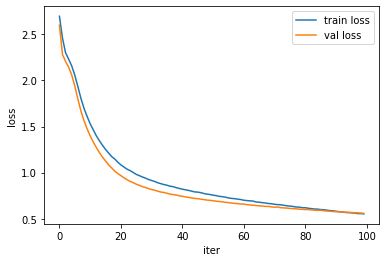

In [ ]:
import matplotlib.pyplot as plt

range_list = [i for i in range(len(train_loss_list))] 
plt.plot(range_list, train_loss_list, label = "train loss")
plt.plot(range_list, val_loss_list, label = "val loss")
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_dataset = POS_Dataset(test_sentence, test_pos, word2idx, dict_pos)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=pad_collate)

model.eval()

def idx2str(idx_list, idx_dict):
  temp_str = []
  for idx in idx_list:
    temp_str.append(idx_dict[idx.item()])
  
  return temp_str

for (x_padded, y_padded, x_lens, y_lens) in test_loader:
  inputs, targets = x_padded.to(device), y_padded.to(device)
  print(idx2str(inputs[0], idx2word))
  print(idx2str(targets[0], idx2pos))
  outputs = model(inputs, x_lens).view(-1, len(dict_pos)).argmax(dim = -1)
  temp_str = []
  for idx in outputs:
    temp_str.append(idx2pos[idx.item()])
  print(temp_str)
  print("-----------------------")
  
  break




['此線', '設', '12', '歲', '以下', '小童', '及', '65', '歲', '或', '以上', '長者', '半', '價', '優惠', '，', '此線', '所有', '巴士', '均', '接受', '八', '達', '通', '卡', '付款', '，', '上車', '付款', '、', '不', '設', '找續', '。']
['NOUN', 'VERB', 'NUM', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'NUM', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'NUM', 'NOUN', 'NOUN', 'PUNCT', 'NOUN', 'DET', 'NOUN', 'ADV', 'VERB', 'NUM', 'VERB', 'PART', 'PART', 'VERB', 'PUNCT', 'VERB', 'VERB', 'PUNCT', 'ADV', 'VERB', 'VERB', 'PUNCT']
['NOUN', 'VERB', 'NUM', 'NOUN', 'NUM', 'NOUN', 'CCONJ', 'PART', 'NOUN', 'CCONJ', 'ADP', 'NOUN', 'NUM', 'NOUN', 'VERB', 'PUNCT', 'NOUN', 'DET', 'NOUN', 'ADV', 'VERB', 'NUM', 'VERB', 'PART', 'PART', 'NOUN', 'PUNCT', 'NOUN', 'NOUN', 'PUNCT', 'ADV', 'VERB', 'NOUN', 'PUNCT']
-----------------------
